In [1]:
import IPython

import pandas as pd
import matplotlib.pyplot as plt
import qiime2 as q2
import seaborn as sns
from qiime2 import Visualization
import matplotlib.cm as cm
import numpy as np  



import os

import matplotlib.pyplot as plt
%matplotlib inline

data_dir = 'livia_data'

# Functional analysis

## What is FUNGuild

FUNGuild is an annotation tool that can predict and classify the ecological roles of the fungi based on their taxonomic assignment. The wanted parameter from this tool was "trophic mode". With the taxonomic assignment, FUNGuild can annotate a trophic mode which describes the ecological role of the fungi.
These roles are patotrophs, saprotroph and symbiotrophs. Pathotrophs gain nutrients by invasion of a host organisms, saprotrophs decomposes non-living organic material like plants and symbiotrophs form mutually beneficial relationships with a host.
An even more specific classifications is represented by the "guilds". As these guilds are too different from each other, they were not taken further into account, as a comparison between them would bee to broad.  

To run the comparison, FUNGuild requires a plain-text taxonomy table. Therefore the Qiime2 taxonomy artifact was first exported to a tsv file. This taxonomy file was then filtered to include only the features that were retained in the previously filtered feature table, to make sure that functional assignments were performed only for features present in the final dataset. The resulting filtered taxonomy table was then formatted according to FUNGuild’s input requirements and then compared with the FUNGuild tool.

Source:
FUNGuild: An open annotation tool for parsing fungal community datasets by ecological guild https://www.sciencedirect.com/science/article/pii/S1754504815000847?via%3Dihub

## FUNGuild annotation

In [4]:
from qiime2 import Artifact
from biom import load_table

# convert qza files to a format readable for FUNGuild
# Prepare paths
taxonomy_qza_path = f"{data_dir}/04/taxonomy.qza"
table_filtered_qza_path = f"{data_dir}/05/table_filtered.qza"

taxonomy_artifact = Artifact.load(taxonomy_qza_path)
taxonomy_artifact.export_data(f"{data_dir}/09")

table_filtered_artifact = Artifact.load(table_filtered_qza_path)
table_filtered_artifact.export_data(f"{data_dir}/09")

# convert from biom to tsv and create a file for the filtered ids, that the ids match for both documents
feature_table_biom_path = f"{data_dir}/09/feature-table.biom"
feature_table_tsv_path = f"{data_dir}/09/feature-table.tsv"
filtered_ids_path = f"{data_dir}/09/filtered_ids.txt"

biom_table = load_table(feature_table_biom_path)
with open(feature_table_tsv_path, "w") as f:
    f.write(biom_table.to_tsv())

with open(feature_table_tsv_path) as infile:
    with open(filtered_ids_path, "w") as outfile:
        for i, line in enumerate(infile):
            if i < 2:
                continue  # Header überspringen
            asv_id = line.split("\t")[0]
            outfile.write(asv_id + "\n")

# Prepare taxonomy for FUNGuild
taxonomy_tsv_path = f"{data_dir}/09/taxonomy.tsv"
filtered_taxonomy_path = f"{data_dir}/09/taxonomy_filtered.tsv"

taxonomy_df = pd.read_csv(taxonomy_tsv_path, sep="\t")
with open(filtered_ids_path) as f:
    asv_ids = set(line.strip() for line in f)

filtered_taxonomy_df = taxonomy_df[taxonomy_df["Feature ID"].isin(asv_ids)]
filtered_taxonomy_df.to_csv(filtered_taxonomy_path, sep="\t", index=False)

funguild_input_path = f"{data_dir}/09/taxonomy_filtered_for_funguild.txt"
funguild_output_path = f"{data_dir}/09/taxonomy_filtered_for_funguild.guilds.tsv"

filtered_taxonomy_df = filtered_taxonomy_df.rename(columns={"Taxon": "taxonomy"})
filtered_taxonomy_df.to_csv(funguild_input_path, sep="\t", index=False)


In [5]:
# Run FUNGuild
os.system(f"git clone https://github.com/UMNFuN/FUNGuild {data_dir}/09/FUNGuild")
os.system(f"python {data_dir}/09/FUNGuild/Guilds_v1.1.py -otu {funguild_input_path} -db fungi")

# Rename the generated file
os.rename(f"{data_dir}/09/taxonomy_filtered_for_funguild.guilds.txt", funguild_output_path)

Cloning into 'livia_data/09/FUNGuild'...


FunGuild v1.1 Beta
Connecting with FUNGuild database ...

Reading in the OTU table: 'livia_data/09/taxonomy_filtered_for_funguild.txt'

Searching the FUNGuild database...
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%

Found 1154 matching taxonomy records in the database.
Dereplicating and sorting the result...
FunGuild tried to assign function to 907 OTUs in 'livia_data/09/taxonomy_filtered_for_funguild.txt'.
FUNGuild made assignments on 709 OTUs.
Result saved to 'livia_data/09/taxonomy_filtered_for_funguild.guilds.txt'

Total calculating time: 7.12 seconds.


In [6]:
funguild_df = pd.read_csv(f"{data_dir}/09/taxonomy_filtered_for_funguild.guilds.tsv", sep="\t")

In [9]:
funguild_df.head(2)

,Feature ID,taxonomy,Confidence,Taxon,Taxon Level,Trophic Mode,Guild,Growth Morphology,Trait,Confidence Ranking,Notes,Citation/Source
0,0048079d52e0b654423c0c89021b8a34,k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_...,0.873261,Pleurotus,13,Pathotroph-Saprotroph,Endophyte-Nematophagous-Plant Pathogen-|Wood S...,Agaricoid,White Rot,Probable,As white_rot (Põlme et al. 2020); As wood_path...,"James TY, et al. 2006. Nature 443:818-822 ((ht..."
1,004c991a685b11054001b8c7d0a68543,k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...,0.940547,Saccharomycetales,7,Saprotroph,Undefined Saprotroph,Yeast,NaN,Possible,NaN,"Sterkenburg E, et al. 2015. New Phytologist 20..."


## FUNGuild data analysis

In [11]:
# The unassigned samples are replaced with "unassigned"
# Trophic mode
funguild_df['Trophic Mode'] = funguild_df['Trophic Mode'].str.strip()

# match "Unassigned" 
funguild_df['Trophic Mode'] = funguild_df['Trophic Mode'].replace({'-': 'Unassigned', '': 'Unassigned'})

# count trophic mode
trophic_mode_counts = funguild_df['Trophic Mode'].value_counts()

print(trophic_mode_counts)


Trophic Mode
Saprotroph                           312
Pathotroph-Saprotroph                212
Unassigned                           198
Pathotroph-Saprotroph-Symbiotroph    157
Saprotroph-Symbiotroph                15
Pathotroph                             8
Pathotroph-Symbiotroph                 3
Pathotroph-Pathotroph-Saprotroph       1
Symbiotroph                            1
Name: count, dtype: int64


In [12]:
# Plots to compare the trophic modes
# First, some colomns have to be renamed
feature_table = pd.read_csv(f"{data_dir}/09/feature-table.tsv", sep='\t', skiprows=1)
feature_table = feature_table.rename(columns={'#OTU ID': 'FeatureID'})

funguild_df = funguild_df.rename(columns={'Feature ID':'FeatureID'})

# Then the feature table can be merged with the funguild table
merged_fg_ft = feature_table.merge(funguild_df, on='FeatureID', how='left')

exclude_cols = ['FeatureID','Guild','Trophic Mode','Confidence']
sample_cols = [c for c in merged_fg_ft.columns if c not in exclude_cols]

# And we create tsv files filtered by the trophic mode

trophic = merged_fg_ft.groupby('Trophic Mode')[sample_cols].sum()
trophic.to_csv(f"{data_dir}/09/trophic_by_sample.tsv", sep='\t')


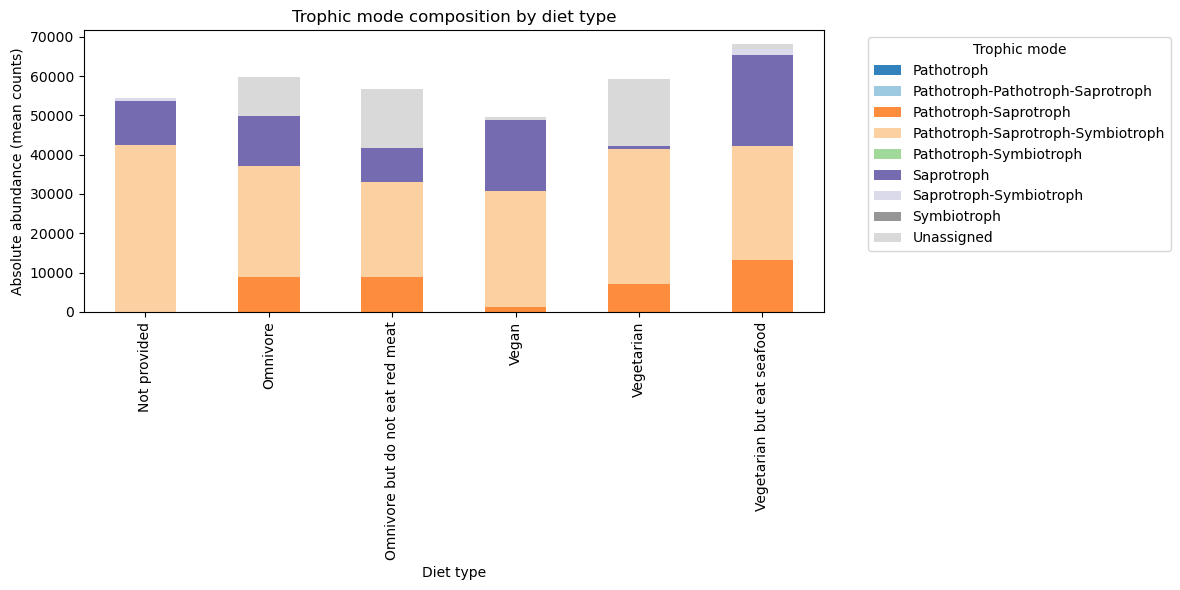

In [21]:
# Trophic mode by diet type

guild_abund = pd.read_csv(f"{data_dir}/09/trophic_by_sample.tsv", sep='\t', index_col=0)
guild_abund_T = guild_abund.T
guild_abund_T.index.name = 'ID'
guild_abund_T = guild_abund_T.reset_index()

metadata = pd.read_csv(f"{data_dir}/05/metadata_ed_rem.tsv", sep='\t')
merged = metadata.merge(guild_abund_T, on='ID')

# Guild-Spalten identifizieren
guild_cols = [c for c in merged.columns if c not in metadata.columns]

# Mittelwerte pro Diet Type berechnen (absolute Counts)
diet_means = merged.groupby('diet_type_sample')[guild_cols].mean()

# Plot: absolute Abundanzen
ax = diet_means.plot(kind="bar", stacked=True, figsize=(12,6), colormap="tab20c")
plt.ylabel("Absolute abundance (mean counts)")
plt.xlabel("Diet type")
plt.title("Trophic mode composition by diet type")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Trophic mode")
plt.tight_layout()
plt.show()

/tmp/ipykernel_470/3671215216.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


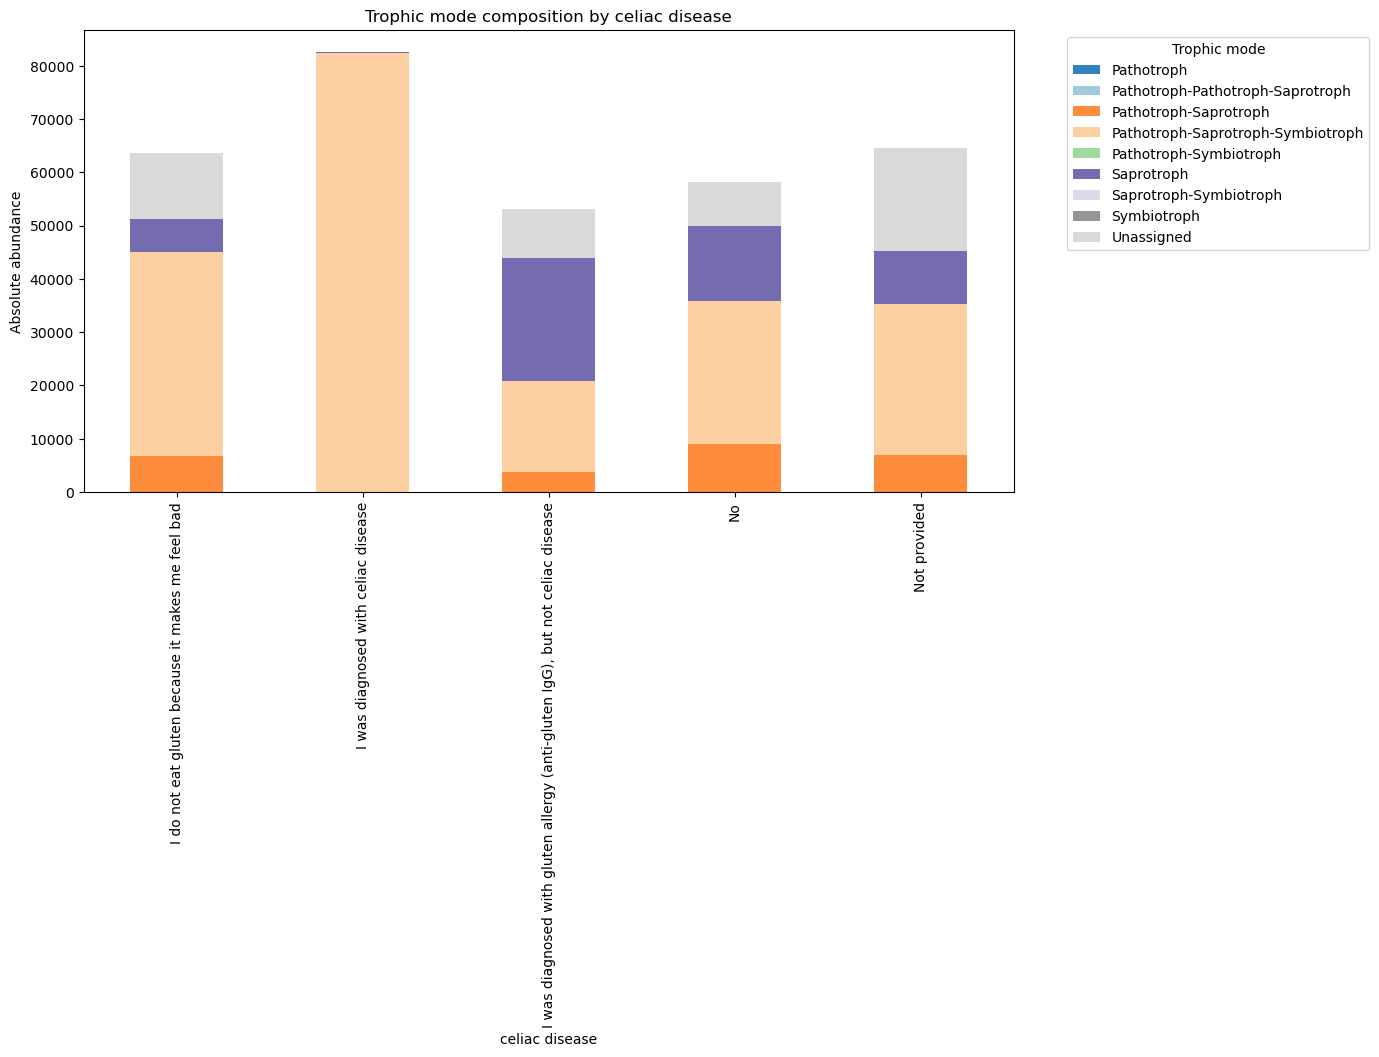

In [22]:
# Trophic mode by celiac disease

guild_abund = pd.read_csv(f"{data_dir}/09/trophic_by_sample.tsv", sep='\t', index_col=0)
guild_abund_T = guild_abund.T
guild_abund_T.index.name = 'ID'
guild_abund_T = guild_abund_T.reset_index()

metadata = pd.read_csv(f"{data_dir}/05/metadata_ed_rem.tsv", sep='\t')
merged = metadata.merge(guild_abund_T, on='ID')

# Guild-Spalten identifizieren
guild_cols = [c for c in merged.columns if c not in metadata.columns]

# Mittelwerte pro Diet Type berechnen (absolute Counts)
diet_means = merged.groupby('gluten_sample')[guild_cols].mean()

# Plot: absolute Abundanzen
ax = diet_means.plot(kind="bar", stacked=True, figsize=(12,6), colormap="tab20c")
plt.ylabel("Absolute abundance")
plt.xlabel("celiac disease")
plt.title("Trophic mode composition by celiac disease")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Trophic mode")
plt.tight_layout()
plt.show()

/tmp/ipykernel_470/398197936.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


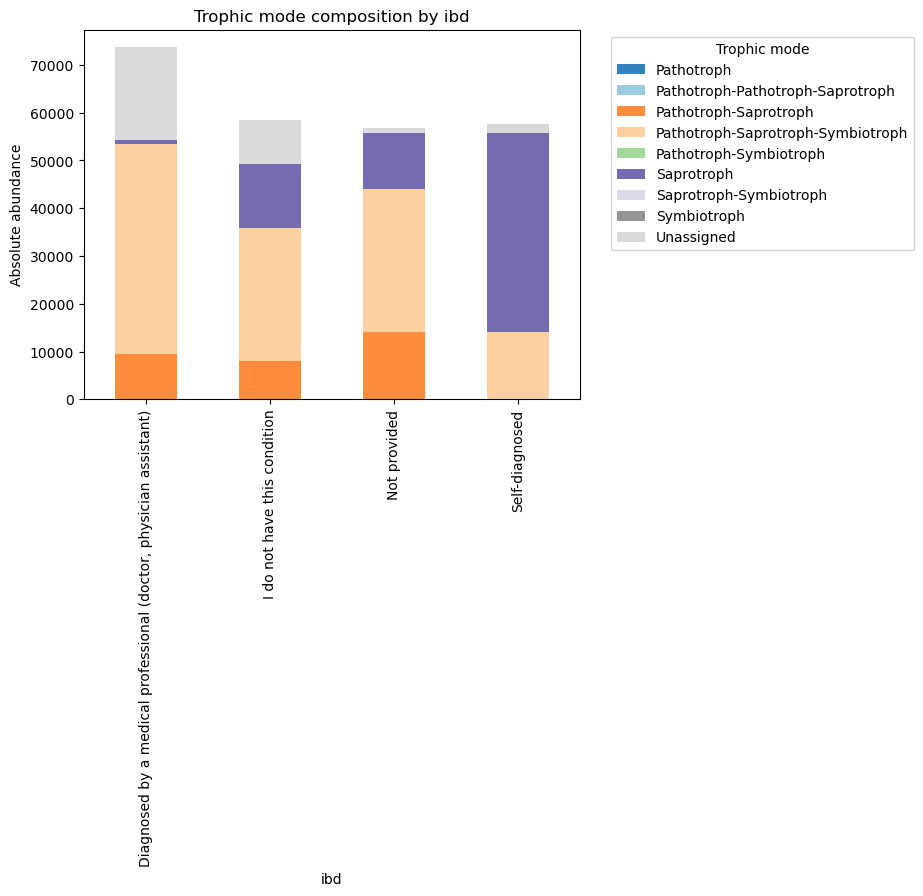

In [23]:
# Trophic mode by ibd

guild_abund = pd.read_csv(f"{data_dir}/09/trophic_by_sample.tsv", sep='\t', index_col=0)
guild_abund_T = guild_abund.T
guild_abund_T.index.name = 'ID'
guild_abund_T = guild_abund_T.reset_index()

metadata = pd.read_csv(f"{data_dir}/05/metadata_ed_rem.tsv", sep='\t')
merged = metadata.merge(guild_abund_T, on='ID')

# Guild-Spalten identifizieren
guild_cols = [c for c in merged.columns if c not in metadata.columns]

# Mittelwerte pro Diet Type berechnen (absolute Counts)
diet_means = merged.groupby('ibd_sample')[guild_cols].mean()

# Plot: absolute Abundanzen
ax = diet_means.plot(kind="bar", stacked=True, colormap="tab20c")
plt.ylabel("Absolute abundance")
plt.xlabel("ibd")
plt.title("Trophic mode composition by ibd")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Trophic mode")
plt.tight_layout()
plt.show()

<div style="background-color: turquoise; padding: 20px;">
To conclude the functional analysis, we look if any visual correlations (therefore without any further statistical analysis) can be seen.
</div>

**Conclusion:** The quantity of saprotrophs compared to symbiotroph or pathotroph is higher among all results. Symbiotroph and pathotroph appear only together with saprotoph, they never appear on their own. This could be because diets rich in plant materials can enhance saprotrophic activity, as the fungal community is oriented towards the decompostion of this plant materials. 
For further analysis, statistcal test would have to been performed and a higher quantity of samples have to be obtained to get a meanigful analysis. 


